[Open in colab](https://colab.research.google.com/github/marcos-vmiranda/pos-pucrj-mvp/blob/main/MVP_ML_MarcosMiranda.ipynb)


**PUC Rio - Pós Graduação em Ciência de Dados e Analytics**
# MVP: *Machine Learning & Analytics*
- **Autor:** Marcos Vinícius de Miranda  
- **Data:** 27/09/2025
- **Matrícula:** 4052025001185
- **Dataset:** [Atrasos em uma base de distribuição de combustíveis](https://raw.githubusercontent.com/marcos-vmiranda/pos-pucrj-mvp/main/atrasos_tratados.csv)



## 1. Escopo, objetivo e definição do problema

Em uma base de distribuição de combustíveis é de grande importância que o atendimento seja feito ao longo do dia de maneira uniforme, a fim de evitar horários de pico que geram excesso de veículos e filas na base, causando insatisfação dos clientes. Os atrasos da chegada dos veículos em relação ao horário agendado prejudicam a eficiência da base, uma vez que a as baias de carregamento ficam vazias aguardando os veículo atrasados.

O objetivo desse projeto é desenvolver um modelo de classificação para prever se um veículo irá atrasar mais que 30 minutos (tempo padrão de tolerância), a partir de informações históricas das viagens de todos os veículos.

A aplicação desse modelo será na antecipação da chamada dos veículos que já estejam na base, em detrimento dos veículos que tenham previsão de atraso.

Essa aplicação é de grande valor para o negócio, pois irá gerar os seguintes benefícios:
  - Evitar que a base fique aguardando um veículo que provavelmente irá atrasar
  - Reduzir o tempo médio de permanência na unidade (TMPU), que é um indicador operacional importante
  - Aumentar a eficiência operacional da base, ou seja, permitir que mais veículos sejam carregados num mesmo tempo
  - Aumentar a taxa de ocupação das baias
  - Melhorar o nível de atendimentos dos clientes, um vez que as filas e os tempos de espera serão reduzidos



## 2. Preparação do ambiente
### 2.1 Instalação de pacotes
Esse trecho verifica se os pacotes necessários para o funcionamento do projeto estão instalados e, caso necessário, os instala.


In [67]:
%pip install -r https://raw.githubusercontent.com/marcos-vmiranda/pos-pucrj-mvp/main/requirements.txt

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




### 2.2. Importação das bibliotecas
Importa as bibliotecas que serão utilizadas no projeto

In [43]:
# Bibliotecas usadas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import (MinMaxScaler,StandardScaler,RobustScaler)
from sklearn.model_selection import (train_test_split,StratifiedKFold,cross_val_score,GridSearchCV)
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import (LogisticRegression,RidgeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

### 2.3. Definição da seed global
Aqui é definida uma semente global, o que é necessário para garantir reprodutibilidade dos resultados, fazendo com que os mesmos números aleatórios sejam gerados em todas as execuções.

In [68]:
seed = 7
np.random.seed(seed) # Para numpy
random_state = seed # Para modelos do sklearn

print("Seed global:", seed)

Seed global: 7


### 2.2 Funções
Aqui são definidas as funções que serão utilizadas no projeto, a fim de deixar o código mais enxuto e organizado.

In [ ]:
def avaliar_classificacao(y_true, y_pred, proba=None):
    # Calcula métricas de avaliação para problemas de classificação
    # parâmetros de entrada:
    #   y_true: rótulos verdadeiros
    #   y_pred: rótulos previstos pelo modelo
    #   proba: probabilidades previstas (opcional, usado para AUC-ROC)
    # Retorna um dicionário com as métricas calculadas
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    return {"accuracy": acc, "recall": recall, "precision": precision, "f1_weighted": f1w}

def criar_pipelines(names,tipoScaler = "MinMaxScaler",parameters=None):
    # Cria pipelines com transformação opcional de escala e os parâmetros para diferentes modelos de classificação
    #
    # OBS: O modelo SVC foi comentado intencionalmente para reduzir o tempo de execução, pois é muito demorado e não apresentou resultados melhores que os outros modelos 
    #
    # parâmetros de entrada:
    #   names: lista de nomes dos modelos a serem criados ou * para todos
    #   tipoScaler: tipo de normalizador a ser usado ("MinMaxScaler", "StandardScaler", "RobustScaler" ou "" para nenhum)
    #   parameters: dicionário com os parâmetros a serem usados (opcional). Caso seja None, usa os parâmetros padrão. 
    # Os modelos que têm opção de utilizar balanceamento de pesos nas classes (class_weight) já vêm com esse parâmetro ajustado para 'balanced'
    # Retorna um dicionário com os pipelines criados
    
    # Instanciando o normalizador MinMaxScaler
    if tipoScaler == "MinMaxScaler":
        scaler = MinMaxScaler()
    elif tipoScaler == "StandardScaler":
        scaler = StandardScaler()
    elif tipoScaler == "RobustScaler":
        scaler = RobustScaler()
    elif tipoScaler == "":
        scaler = None
    else:
        raise ValueError("Tipo de scaler desconhecido")

    # Cria os pipelines
    pipelines = []
    for name in names:
        if (name == "LogisticRegression") or (name == "*"):
            # Se o dicionário de parâmetros for fornecido, usa os parâmetros especificados
            if parameters and parameters['LogisticRegression']:
                log_reg = ('LogisticRegression', LogisticRegression(random_state=seed,class_weight='balanced',**parameters['LogisticRegression']))
            else:
                log_reg = ('LogisticRegression', LogisticRegression(random_state=seed,class_weight='balanced'))
            pipelines.append(('LogisticRegression', Pipeline([('scaler',scaler),log_reg])))
        if (name == "RandomForest") or (name == "*"):
            if parameters and parameters['RandomForest']:
                random_forest = ('RandomForest', RandomForestClassifier(random_state=seed,class_weight='balanced',**parameters['RandomForest']))
            else:
                random_forest = ('RandomForest', RandomForestClassifier(random_state=seed,class_weight='balanced'))
            pipelines.append(("RandomForest", Pipeline([('scaler',scaler),random_forest])))
        if (name == "Ridge") or (name == "*"):
            if parameters and parameters['Ridge']:
                ridge = ('Ridge', RidgeClassifier(random_state=seed,class_weight='balanced',**parameters['Ridge']))
            else:
                ridge = ('Ridge', RidgeClassifier(random_state=seed,class_weight='balanced'))
            pipelines.append(("Ridge", Pipeline([('scaler',scaler),ridge])))
        if (name == "KNN") or (name == "*"):
            if parameters and parameters['KNN']:
                knn = ('KNN', KNeighborsClassifier(**parameters['KNN']))
            else:
                knn = ('KNN', KNeighborsClassifier())
            pipelines.append(("KNN", Pipeline([('scaler',scaler),knn])))
        if (name == "NaiveBayes") or (name == "*"):
            if parameters and parameters['NaiveBayes']:
                naive_bayes = ('NaiveBayes', GaussianNB(**parameters['NaiveBayes']))
            else:
                naive_bayes = ('NaiveBayes', GaussianNB())
            pipelines.append(("NaiveBayes", Pipeline([('scaler',scaler),naive_bayes])))
        if (name == "SVM") or (name == "*"):
            if parameters and parameters['SVM']:
                svm = ('SVM', SVC(random_state=seed,class_weight='balanced',**parameters['SVM']))
            else:
                svm = ('SVM', SVC(random_state=seed,class_weight='balanced'))
            #pipelines.append(("SVM", Pipeline([('scaler',scaler),svm])))
        if (name == "AdaBoost") or (name == "*"):
            if parameters and parameters['AdaBoost']:
                adaboost = ('AdaBoost', AdaBoostClassifier(random_state=seed,**parameters['AdaBoost']))
            else:
                adaboost = ('AdaBoost', AdaBoostClassifier(random_state=seed))
            pipelines.append(("AdaBoost", Pipeline([('scaler',scaler),adaboost])))
        if (name == "GradientBoosting") or (name == "*"):
            if parameters and parameters['GradientBoosting']:
                gradient_boosting = ('GradientBoosting', GradientBoostingClassifier(random_state=seed,**parameters['GradientBoosting']))
            else:
                gradient_boosting = ('GradientBoosting', GradientBoostingClassifier(random_state=seed))
            pipelines.append(("GradientBoosting", Pipeline([('scaler',scaler),gradient_boosting])))
    return pipelines

def get_hiperparametros(model_name):
    # Retorna um dicionário com os hiperparâmetros a serem otimizados para cada modelo no GridSearchCV
    # parâmetros de entrada:
    #   model_name: nome do modelo
    # Retorna um dicionário com os parâmetros e seus valores possíveis
    if model_name == "LogisticRegression":
        return {
            'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10],
            'LogisticRegression__penalty': ['l2'],
            'LogisticRegression__solver': ['liblinear', 'lbfgs','saga','sag','newton-cg','newton-cholesky'],
            'LogisticRegression__max_iter': [100, 200],
        }
    elif model_name == "RandomForest":
        return {
            'RandomForest__n_estimators': [100, 200],
            'RandomForest__max_features': [2, 3],
            'RandomForest__min_samples_split': [2, 5, 10]
        }
    elif model_name == "Ridge":
        return {
            'Ridge__alpha': [0.001, 0.01, 0.1, 1, 10],
            'Ridge__solver': ['auto', 'saga', 'cholesky', 'lsqr', 'sparse_cg', 'sag'],
        }
    elif model_name == "KNN":
        return {
            'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
            'KNN__weights': ['uniform', 'distance'],            
            'KNN__metric': ["euclidean", "manhattan", "minkowski"],
        }
    elif model_name == "NaiveBayes":
        return {
            'NaiveBayes__var_smoothing': np.logspace(0,-9, num=100)
        }
    elif model_name == "SVM":
        return {
            'SVM__C': [0.1, 1, 10, 100],
            'SVM__kernel': ['linear', 'rbf', 'poly'],
            'SVM__gamma': ['scale', 'auto']
        }
    elif model_name == "AdaBoost":
        return {
            'AdaBoost__n_estimators': [50, 100, 200],
            'AdaBoost__learning_rate': [0.01, 0.1, 1]
        }
    elif model_name == "GradientBoosting":
        return {
            'GradientBoosting__n_estimators': [100, 200],
            'GradientBoosting__max_features': [1, 2],
            'GradientBoosting__min_samples_split': [5, 10]    
        }
    else:
        return {}
          



## 3. Carga e descrição do dataset
O dataset foi obtido a partir de uma extração do banco de dados corporativo de uma empresa de distribuição de combustíveis no período 01/01/2025 a 31/05/2025. O  script de extração foi desenvolvido na linguagem ObjectScript da ferramenta Intersystems IRIS, devido ao acesso direto que a ferramenta já tinha ao banco. Nesse script foram feitas algumas transformações para tornar todos os dados string em numéricos e para calcular o campo PercAtraso, descrito abaixo. 

A escolha inicial dos atributos levou em consideração o contexo logístico e os fatores externos que poderiam influenciar o atraso, como dados do veículo (quantidade total), histórico de atrasos do veículo, dados do agendamento (dia da semana, turno) e dados logísticos (tipo de operaçao carga ou descarga, tipo de frete CIF ou FOB, ordem da viagem no dia).

Os campos do dataset são:
- Quantidade: Quantidade total do veículo, em múltiplos de 10000 litros (Ex: 1,2,3,4)
- DiaDaSemana: Dia da semana sendo 1-Domingo, 2-Segunda, 3-Terça, 4-Quarta, 5-Quinta, 6-Sexta, 7-Sábado
- Turno: Turno do carregamento, sendo 0-Madrugada (0 às 5:59hs), 1-Manhã (6 às 11:59), 2-Tarde (12 às 17:59), 3-Noite (18 às 23:59)
- TipoFrete: Tipo de frete, sendo 0-CIF (frete pago pelo vendedor), 1-FOB (frete pago pelo comprador)
- TipoOperacao: Tipo da operação, sendo 0-Carga, 1-Descarga
- OrdemViagem: Ordem da viagem do veículo no dia, uma vez que o mesmo veículo pode ir mais de uma vez no terminal (exemplo: 1, 2, 3).
- PercAtraso: Percentual de atraso do veículo no período analisado (Ex: 0.3 seria 30% de atrasos no período)
- Atraso: variável target, sendo 0 (não atrasou mais que 30 minutos) ou 1 (atrasou mais que 30 minutos)

In [62]:
url = "https://raw.githubusercontent.com/marcos-vmiranda/pos-pucrj-mvp/main/atrasos_tratados.csv"
# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# remove as linhas que tiverem algum valor NaN, pois prejudicam o funcionamento de alguns modelos
dataset = dataset.dropna(axis=0, how='any').dropna(axis=1, how='any')

# exibe informações do dataset
print("\nInformações do dataset:\n")
dataset.info()

# mostra as primeiras linhas do dataset
print("\nPrimeiras linhas do dataset:\n")
display(dataset.head(5))

# verifica o tipo de cada atributo do dataset
print("\nTipo de cada atributo do dataset:\n")
print(dataset.dtypes)



Informações do dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22807 entries, 0 to 22806
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Quantidade    22807 non-null  int64  
 1   DiaDaSemana   22807 non-null  int64  
 2   Turno         22807 non-null  int64  
 3   TipoFrete     22807 non-null  int64  
 4   TipoOperacao  22807 non-null  int64  
 5   OrdemViagem   22807 non-null  int64  
 6   PercAtraso    22807 non-null  float64
 7   Atraso        22807 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 1.4 MB

Primeiras linhas do dataset:



,Quantidade,DiaDaSemana,Turno,TipoFrete,TipoOperacao,OrdemViagem,PercAtraso,Atraso
0,6,5,1,0,1,1,0.2,0
1,6,5,1,0,1,1,0.1,0
2,6,6,2,0,1,1,0.1,0
3,6,5,1,0,1,1,0.2,0
4,6,5,2,0,0,1,0.0,0



Tipo de cada atributo do dataset:

Quantidade        int64
DiaDaSemana       int64
Turno             int64
TipoFrete         int64
TipoOperacao      int64
OrdemViagem       int64
PercAtraso      float64
Atraso            int64
dtype: object



## 4 Análise exploratória dos dados
Nessa etapa são analisadas as características dos dados, a fim de identificar padrões e anomalias que precisem ser tratadas.

### 4.1. Distribuição das classes

O dataset está bastante desbalanceado, devido ao maior número de ocorrências de não-atraso, como pode ser visto pelo comando abaixo. Esse é o comportamento comun nas bases de distribuição, sendo necessário aplicar uma ou mais técnicas de balanceamento para se alcançar melhores resultados no treinamento dos modelos.


In [47]:
# Agrupa features pelo campo target
print("\nDistribuição da classe target:\n")
print(dataset.groupby('Atraso').size())



Distribuição da classe target:

Atraso
0    21036
1     1771
dtype: int64


### 4.2. Análise estatística e histograma

A análise a seguir mostra a distribuição das variáveis utilizando histogramas e análise estatística. 

É possível notar que as colunas estão em escalas diferentes, uma vez que algumas estão com valores de 1 a 7 e outras estão com valores entre 0 e 1. Dessa forma faz-se necessário aplicar alguma técnica de normalização ou padronização para trazer todas as colunas para uma mesma escala.

Algumas variáveis possuem uma tendência central muito concentrada num único valor. No caso da variável "TipoOperacao", isso mostra o grande número de carregamentos em relação às descargas. No caso da variável "OrdemViagem", mostra que a grande maioria dos veículos só faz uma viagem por dia.
A variabilidade não é alta, uma vez que a faixa de valores possíveis não é exageradamente dispersa.

Não foram percebidos outliers nesse conjunto de dados, dispensando esse tratamento.





Histograma do dataset:



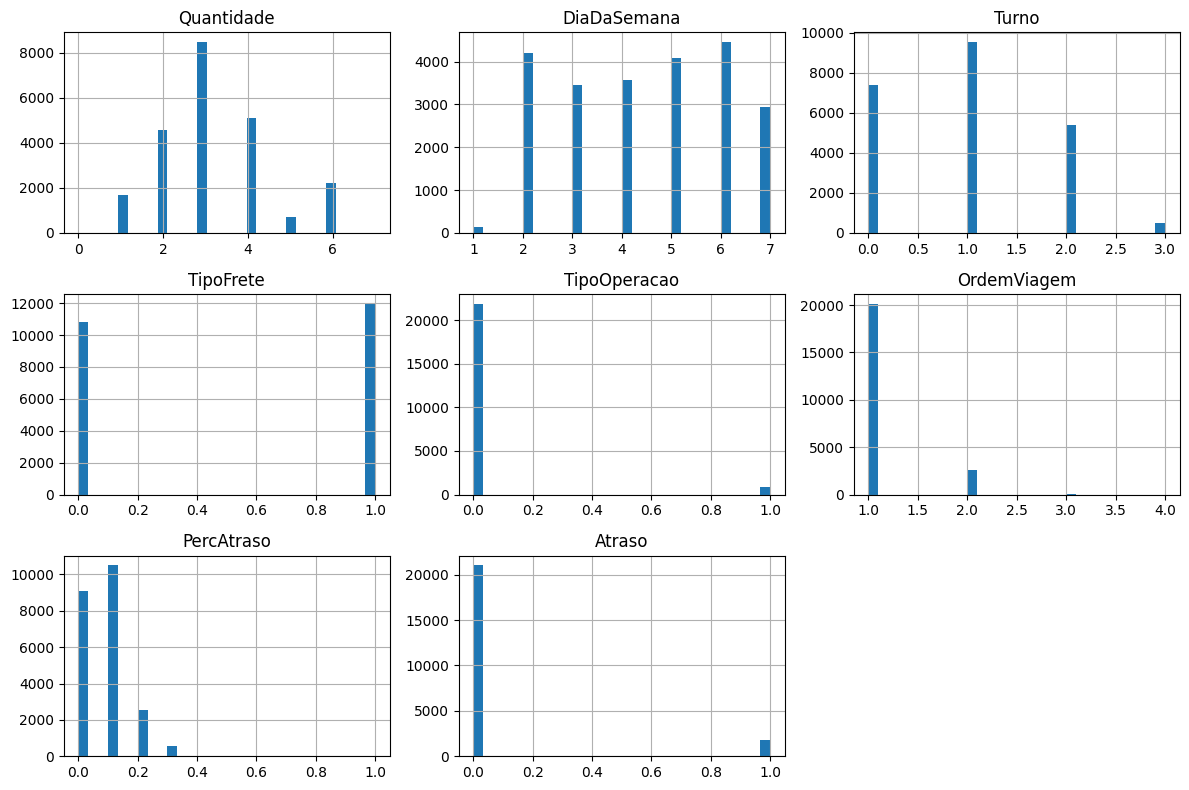

In [48]:
# Exibe os histogramas de todas as variáveis numéricas
print("\nHistograma do dataset:\n")
dataset.hist(bins=30, figsize=(12,8), layout=(3,3), sharex=False, sharey=False)
plt.tight_layout()
plt.show()


### 4.3 Análise estatística com boxplot

Nessa etapa é feita uma análise da distribuição estatística das variáveis. O boxplot permite essa análise de forma visual, enquanto o comando 'describe' o faz de forma tabular.
O boxplot permite analisar o seguinte:
- Os campos 'TipoOperacao', 'OrdemViagem' e 'PercAtraso' possuem alguns valores que poderiam ser considerados outliers (valores atípicos), uma vez que ocorrem poucas vezes. Porém esses valores estão dentro do esperado para o cenário.
- A análise da linha central (mediana), que mostra a tendência dos valores, está coerente.
- A dispersão dos dados, identificada pelo tamanho da caixa, também está aceitável.

O sumário mostra valores estatísticos como médias e medianas, máximos e mínimos. Esses valores também estão dentro do esperado para o cenário.




Boxplot dos atributos numéricos


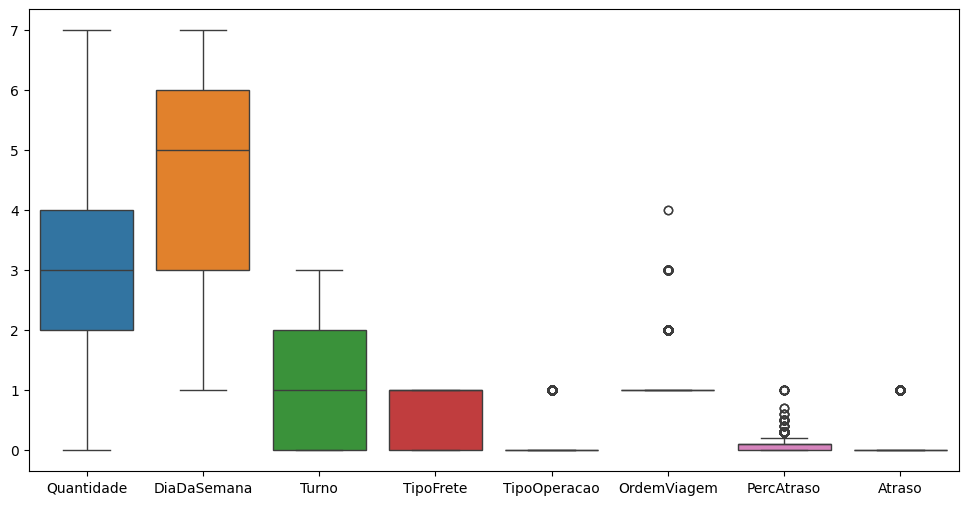


Sumário estatístico do dataset:



,Quantidade,DiaDaSemana,Turno,TipoFrete,TipoOperacao,OrdemViagem,PercAtraso,Atraso
count,22807.000000,22807.000000,22807.000000,22807.000000,22807.000000,22807.000000,22807.000000,22807.000000
mean,3.228132,4.419783,0.955102,0.525058,0.040470,1.119569,0.078108,0.077652
std,1.293879,1.697130,0.802140,0.499383,0.197063,0.334839,0.081998,0.267628
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,3.000000,5.000000,1.000000,1.000000,0.000000,1.000000,0.100000,0.000000
75%,4.000000,6.000000,2.000000,1.000000,0.000000,1.000000,0.100000,0.000000
max,7.000000,7.000000,3.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [49]:

# boxplot com Seaborn
print("\n")
print("Boxplot dos atributos numéricos")
plt.figure(figsize=(12,6))
sns.boxplot(data = dataset)
plt.show()

# exibe um sumário estatístico
print("\nSumário estatístico do dataset:\n")
dataset.describe()


### 4.4 Análise das correlações

Nessa etapa é usado o comando seaborn.heatmaps para criar mapas de calor mostrando a correlação entre as variáveis. Essa análise é importante para identificar possíveis redundâncias e relações entre as variáveis

Aqui é possível identificar que a variável com maior correlação com o target é o campo 'PercAtraso'

As outras variáveis possuem uma baixa correlação com o target (menor que 0.1). Apesar disso foi decidido mantê-las no dataset.

O campo 'Turno' possui a menor correlação (0.0062). 

Em relação à correlação entre variáveis, percebe-se que 'TipoFrete' e 'PercAtraso' possuem a mais alta correlação (-0.31), porém não é alta o suficiente (maior que 0.85) para ter que remover uma delas.

O campo 'TipoFrete' possui uma correlação negativa com o target, ou seja, quanto maior o valor, menor o target.

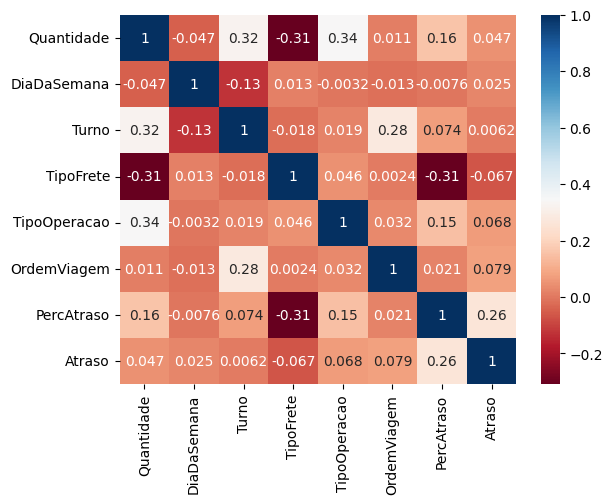

In [50]:

corr = dataset.corr(method='pearson') # utilizado o método pearson, pois é mais adequado a targets binários

# matriz de correlação com seaborn
sns.heatmap(corr, annot=True, cmap='RdBu');
plt.show()


## 5. Transformação dos dados
### 5.1. Balanceamento
Na análise de distribuição das classes feita anteriormente foi verificado o alto desbalanceamento do dataset, evidenciando a necessidade de aplicar uma ou mais técnicas de balanceamento.

Antes de tomar essa decisão, o treinamento dos modelos foi realizado sem aplicar balanceamento, mas o resultado não foi satisfatório.

Foi escolhida a técnica de oversampling SMOTE (Syntetic Minority Oversampling Technique), já que a classe minoritária é muito pequena em relação à majoritária e o uso de undersampling poderia causar a perda de muitos dados.
O balanceamento foi aplicado para sobreamostrar a classe minoritária para ter 70% do número de exemplos da classe majoritária porque o desbalanceamento original é muito alto e o SMOTE de 100% poderia gerar muitos dados sintéticos, o que poderia levar a overfiting.

Como o dataset permaneceu desbalanceado, foi utilizado em conjunto a técnica do ajuste de pesos, a fim de atribuir maior peso à classe minoritária. Ela foi aplicada em alguns dos modelos analisados como LogisticRegression e RandomForest utilizando o parâmetro 'class_weight="balanced"'.

In [51]:
# Verifica a distribuição das classes antes do balanceamento
print("\nDistribuição das classes antes do SMOTE:\n")
print(dataset.groupby('Atraso').size())

# Separa as features do target
X = dataset.drop(columns=['Atraso'])
y = dataset['Atraso']

# Aplica o SMOTE em 70% do desbalanceamento
smote = SMOTE(sampling_strategy=0.7, random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstrói o dataset balanceado
dataset_balanceado = pd.concat([X_resampled, y_resampled], axis=1)

# Verifica a distribuição das classes balanceadas
print("\nDistribuição das classes após SMOTE:\n")
print(dataset_balanceado.groupby('Atraso').size())



Distribuição das classes antes do SMOTE:

Atraso
0    21036
1     1771
dtype: int64

Distribuição das classes após SMOTE:

Atraso
0    21036
1    14725
dtype: int64


## 6. Separação em conjunto de treino e teste

Foi utilizada a técnica de holdout separando em 80% dos dados para o treino e 20% para o teste. Foi utilizado o parâmetro stratify=y para garantir que a divisão entre treino e teste mantenha a mesma distribuição de classes da variável target.


In [52]:
test_size = 0.20 # tamanho do conjunto de teste

# Separação em conjuntos de treino e teste
array = dataset_balanceado.values
numCols = len(dataset_balanceado.columns)
X = array[:,0:numCols-1]
y = array[:,numCols-1].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

print("Tamanho do conjunto de treino:", X_train.shape)
print("Distribuição das classes no conjunto de treino:\n", pd.Series(y_train).value_counts())
print("\nTamanho do conjunto de Teste:", X_test.shape)
print("Distribuição das classes no conjunto de Teste:\n", pd.Series(y_test).value_counts())

Tamanho do conjunto de treino: (28608, 7)
Distribuição das classes no conjunto de treino:
 0    16828
1    11780
Name: count, dtype: int64

Tamanho do conjunto de Teste: (7153, 7)
Distribuição das classes no conjunto de Teste:
 0    4208
1    2945
Name: count, dtype: int64


## 7. Avaliação dos modelos

Como o dataset ainda está desbalanceado, mesmo após o balanceamento a escolha da métrica é muito importante. 

O uso do scoring accuracy não é recomendado nesses casos, pois o modelo pode acertar quase tudo prevendo só "0" e ainda assim parecer "bom", mas não terá utilidade.

Nesse cenário, é melhor utilizar um scoring que leve em conta o desbalanceamento, como 'precision', 'recall' ou 'f1'.

O scoring precision minimiza os falsos positivos. Nesse estudo a precisão é importante para evitar o excesso de alertas falsos de atraso, o que poderia gerar ações indesejadas.

O recall minimiza os falsos negativos. Nesse estudo o recall é importante para que os casos reais de atraso sejam de fato detectados e as ações cabíveis sejam tomadas.

Foi escolhido o scoring 'f1', que é uma média harmônica entre precision e recall, uma vez que no problema em análise os falsos positivos e falsos negativos são igualmente problemáticos.

### 7.1. Validação cruzada
Foi utilizada a validação cruzada cross_val_score da bilbioteca scikit-learn para avaliar com a mesma métrica (f1) todos os modelos candidatos usando o conjunto de treino dividido em 5 partições. Como cada modelo é treinado com os dados de uma partição e testado com as outras e resulta numa performance média, essa é uma validação mais confiável do que avaliar somente um conjunto de treino e teste.

Foi utilizada a técnica **`StratifiedKFold`** para dividir as partições, que é apropriada a esse problema de classificação, utilizando k = 5 para o número de divisões. Essa técnica garante que, em cada partição, a proporção das classes da variável target seja igual à do conjunto original.

Resultado da validação cruzada para cada modelo: média e desvio padrão

LogisticRegression: 0.629 e 0.007
RandomForest: 0.740 e 0.012
Ridge: 0.623 e 0.009
KNN: 0.664 e 0.015
NaiveBayes: 0.513 e 0.009
AdaBoost: 0.646 e 0.011
GradientBoosting: 0.663 e 0.005


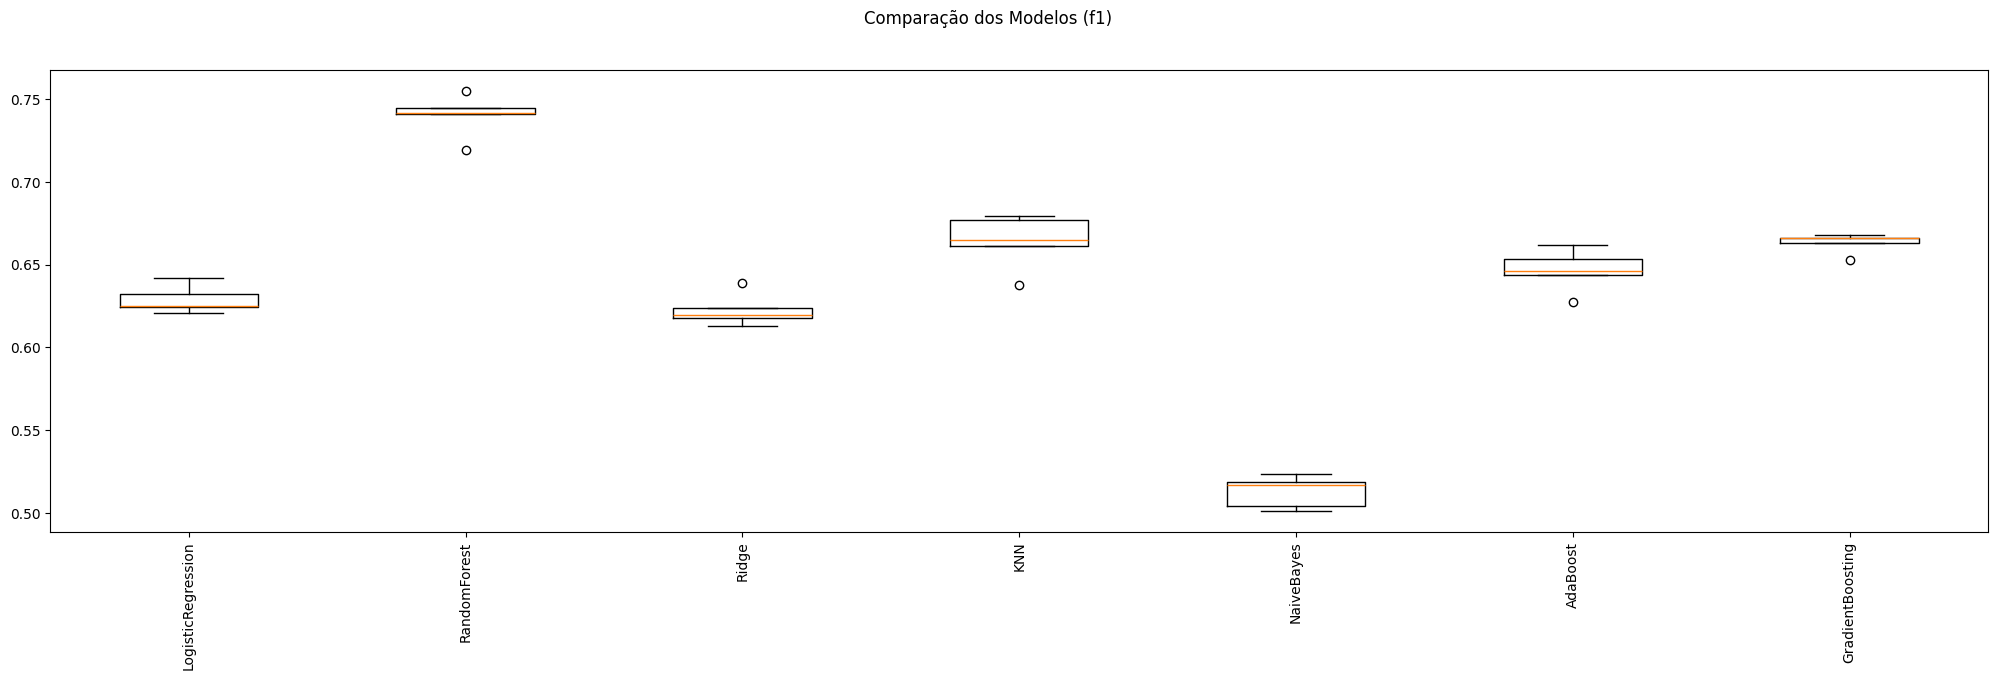

In [53]:

pipelines = criar_pipelines(['*'],'MinMaxScaler') # cria pipelines para todos os modelos disponíveis

scoring = 'f1'
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

results = []
names = []
print("Resultado da validação cruzada para cada modelo: média e desvio padrão\n")
# Executando os pipelines
for name, model in pipelines:     
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f e %.3f" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos (%s)' % scoring)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()


### 7.2. Otimização de Hiperparâmetros

A validação cruzada mostrou que os 2 modelos com melhor avaliação na validação cruzada com parâmetros padrão foram o RandomForest e o GradientBoosting, considerando a maior média e o menor desvio padrão. Entretanto, o resultado ficou bem próximo dos outros modelos. 

A partir disso, foi aplicada a técnica do GridSearchCV para fazer o tuning dos hiperparâmetros e melhorar o resultado desses 2 modelos.

A função criar_pipelines encapsula a criação dos pipelines dos modelos com aplicação de normalização e, nesse caso, utilizando os hiperparâmetros padrão.

A função get_hiperparâmetros encapsula a criação de um dicionário com os valores possíveis para otimização em cada modelo.

In [54]:

pipelines = criar_pipelines(['RandomForest','GradientBoosting'], 'MinMaxScaler') # cria pipelines para os modelos escolhidos

best_params = {} # dicionário para armazenar os melhores parâmetros de cada modelo
print("\nMelhores parâmetros encontrados para os modelos\n")
# Prepara e executa o GridSearchCV
for name, model in pipelines:
    param_grid = get_hiperparametros(name) #Obtém os hiperparâmetros a serem otimizados
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Armazena os melhores parâmetros num dicionário best_params para uso no posterior
    # Manipula o nome das chaves do dicionário, removendo o prefixo 'NomeDoModelo__' necessário para o GridSearchCV
    best_params[name] = {key.replace(name+'__', ''): value for key, value in grid.best_params_.items()}
    
    # imprime a melhor configuração
    print("%s - Melhor: %f usando %s" % (name, grid.best_score_, best_params[name]))


Melhores parâmetros encontrados para os modelos

RandomForest - Melhor: 0.740668 usando {'max_features': 2, 'min_samples_split': 2, 'n_estimators': 200}
GradientBoosting - Melhor: 0.667876 usando {'max_features': 2, 'min_samples_split': 10, 'n_estimators': 200}


### 7.3. Comparação dos modelos com hiperparâmetros ajustados

O GridSearchCV conseguiu encontrar um novo conjunto de parâmetros que melhorou um pouco a performance dos 2 modelos analisados.

Nessa etapa os 2 modelos são treinados utilizando os hyperparâmetros ajustados e depois foram comparados com o baseline, que é o modelo dummy com estratégia 'stratified'. Essa estratégia escolhe o valor do target de maneira aleatória.

A comparação com o baseline mostrou que ambos foram melhores em todas as métricas.

A comparação entre os 2 modelos mostrou que o modelo 'RandomForest' foi melhor em todas as métricas em relação ao "GradientBosting'.

In [55]:
pipelines = criar_pipelines(['RandomForest','GradientBoosting'],"MinMaxScaler",best_params) # cria pipelines para os modelos escolhidos

results = {}

# Instanciando o normalizador MinMaxScaler
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Instanciando o classificador baseline (dummy)
baseline = DummyClassifier(strategy="stratified", random_state=seed)
pipeBaseline = Pipeline([min_max_scaler,('DummyClassifier', baseline)])
t0 = time.time()
pipeBaseline.fit(X_train, y_train)
t1 = time.time()
y_pred = pipeBaseline.predict(X_test)
proba = pipeBaseline.predict_proba(X_test) if hasattr(pipeBaseline, "predict_proba") else None
results["baseline"] = avaliar_classificacao(y_test, y_pred, proba)
results["baseline"]["train_time_s"] = round(t1 - t0, 3)

# Executando os pipelines
for name, pipe in pipelines:
    t0 = time.time()
    pipe.fit(X_train, y_train)
    t1 = time.time()
    y_pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
    results[name] = avaliar_classificacao(y_test, y_pred, proba)
    results[name]["train_time_s"] = round(t1 - t0, 3)

pd.DataFrame(results).T


,accuracy,recall,precision,f1_weighted,train_time_s
baseline,0.512652,0.512652,0.511756,0.512191,0.011
RandomForest,0.763456,0.763456,0.774912,0.765255,3.008
GradientBoosting,0.747379,0.747379,0.745340,0.743807,2.200


### 7.4. Análise da matriz de confusão

A matriz de confusão é uma ferramenta para avaliar o desempenho de modelos de classificação.
Ela mostra, em formato de tabela, a quantidade de previsões corretas e incorretas feitas pelo modelo, separando os resultados em categorias:

- Verdadeiros Positivos (VP): casos positivos corretamente classificados.
- Falsos Positivos (FP): casos negativos classificados como positivos.
- Verdadeiros Negativos (VN): casos negativos corretamente classificados.
- Falsos Negativos (FN): casos positivos classificados como negativos.

A matriz de confusão foi utilizada aqui para mostrar onde os modelos estão acertando ou errando e os tipos de erro (por exemplo, se um modelo está errando mais ao prever atrasos ou não atrasos). 

O baseline, que é o modelo dummy com valores aleatórios, conseguiu uma taxa razoável de acertos positivos e negativos, porém a performance foi pior do que os outros modelos.

Ao comparar os 2 modelos treinados, vê-se que o Random Forest possui mais falsos positivos do que o Gradient Bosting (1103 vs 699), ou seja, veículos que foram detectados como atrasados de forma errada. 

Entretanto, a taxa de verdadeiros positivos do Random Forest em relação ao GradientBoosting foi melhor (2356 vs 1837). Nesse aspecto o modelo Random Forest foi melhor que o Gradient Bosting.

Essa análise da matriz corrobora a análise das métricas feita no item 7.3, onde o Random Forest teve a melhor performance.

Ao analisar o resultado do classification_report, considerando a métrica f1 de cada classe, têm-se o Random Forest obteve a melhor pontuação.

Diante disso, o melhor modelo encontrado foi o Random Forest. Além das melhores métricas f1, também teve a melhor taxa de verdadeiros positivos, sem uma taxa absurda de falso positivos.

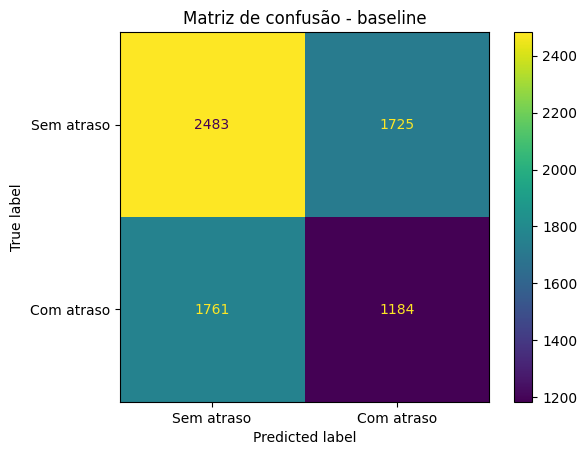


Avaliação de Classificação Baseline:
   accuracy    recall  precision  f1_weighted
1  0.574807  0.574807   0.812702     0.657407

Relatório de Classificação Baseline (por classes do target):
              precision    recall  f1-score   support

  Sem atraso       0.90      0.59      0.71      3939
  Com atraso       0.10      0.40      0.17       459

    accuracy                           0.57      4398
   macro avg       0.50      0.50      0.44      4398
weighted avg       0.81      0.57      0.66      4398



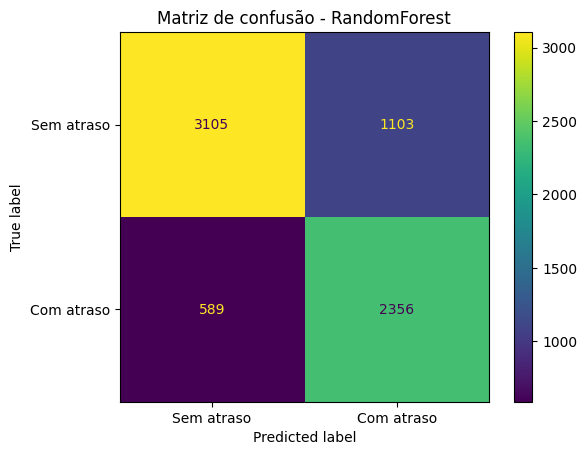


Avaliação de Classificação RandomForest:
   accuracy    recall  precision  f1_weighted
1  0.735334  0.735334   0.853676      0.77999

Relatório de Classificação RandomForest (por classes do target):
              precision    recall  f1-score   support

  Sem atraso       0.93      0.76      0.84      3939
  Com atraso       0.20      0.51      0.29       459

    accuracy                           0.74      4398
   macro avg       0.56      0.63      0.56      4398
weighted avg       0.85      0.74      0.78      4398



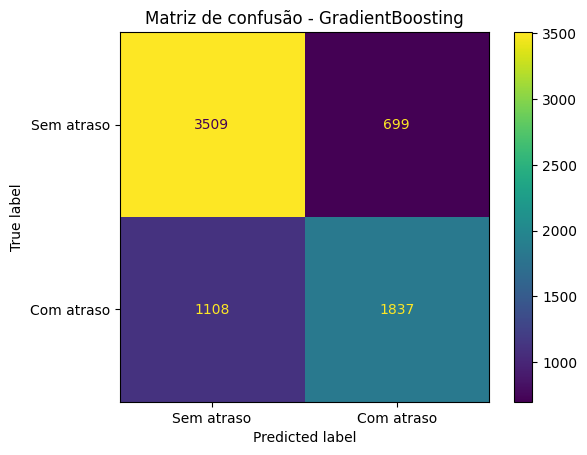


Avaliação de Classificação GradientBoosting:
   accuracy    recall  precision  f1_weighted
1  0.781037  0.781037   0.886861      0.81744

Relatório de Classificação GradientBoosting (por classes do target):
              precision    recall  f1-score   support

  Sem atraso       0.96      0.79      0.87      3939
  Com atraso       0.28      0.70      0.40       459

    accuracy                           0.78      4398
   macro avg       0.62      0.74      0.63      4398
weighted avg       0.89      0.78      0.82      4398



In [65]:
ConfusionMatrixDisplay.from_estimator(pipeBaseline, X_test, y_test, display_labels=['Sem atraso', 'Com atraso'])
plt.title("Matriz de confusão - " + "baseline")
plt.show()
# Faz as previsões com o pipeline do melhor modelo treinado
predictions = pipeBaseline.predict(X)

# Exibe os relatórios de classificação
print("\nAvaliação de Classificação Baseline:")
proba = pipeBaseline.predict_proba(X) if hasattr(pipeBaseline, "predict_proba") else None
results = {}
results[1] = avaliar_classificacao(y, predictions, proba)
print(pd.DataFrame(results).T)

print("\nRelatório de Classificação Baseline (por classes do target):")
print(classification_report(y, predictions, target_names=['Sem atraso', 'Com atraso']))

for name, pipe in pipelines:   
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, display_labels=['Sem atraso', 'Com atraso'])
    plt.title("Matriz de confusão - " + name)
    plt.show()
    # Faz as previsões com o pipeline do melhor modelo treinado
    predictions = pipe.predict(X)
    
    # Exibe os relatórios de classificação
    print("\nAvaliação de Classificação %s:" % name)
    proba = pipe.predict_proba(X) if hasattr(pipe, "predict_proba") else None
    results = {}
    results[1] = avaliar_classificacao(y, predictions, proba)
    print(pd.DataFrame(results).T)

    print("\nRelatório de Classificação %s (por classes do target):" % name)
    print(classification_report(y, predictions, target_names=['Sem atraso', 'Com atraso']))



## 8. Escolha do modelo e treinamento final

Diante dos resultados da análise das métricas e da análise das matrizes de confusão, o melhor método para o problema em questão é o Random Forest com parâmetros otimizados. 

Esse método é um algoritmo do tipo ensemble (combina vários modelos), baseado em árvores de decisão. Ele constrói várias árvores de decisão independentes durante o treinamento e, para cada nova amostra, faz a previsão baseada na votação dos resultados dessas árvores. Isso reduz o risco de overfitting e melhora a generalização do modelo, pois os erros de cada árvore tendem a ser compensados pelas outras.

Segue abaixo a descrição de cada hiperparâmetro utilizado:
- class_weight='balanced': faz com que o algoritmo ajuste automaticamente o peso de cada classe de forma inversamente proporcional à sua frequência no conjunto de dados, ou seja, classes minoritárias recebem mais peso.
- max_features=2: em cada divisão (split) da árvore, apenas 2 features (atributos) serão consideradas aleatoriamente para escolher a melhor divisão.
- n_estimators=200: define que a floresta será composta por 200 árvores de decisão.
- random_state=7: semente comum para todo o projeto

Finalmente, foi realizado o treinamento utilizando todo o conjunto de dados

In [57]:
pipeline = criar_pipelines(['RandomForest'],"MinMaxScaler",best_params)
pipe_best_model = pipeline[0][1] # seleciona o primeiro modelo da lista (RandomForest)

# Exibe o pipeline do melhor modelo
print("\nPipeline do melhor modelo:\n")
print(pipe_best_model)

# Preparação do modelo com TODO o dataset
pipe_best_model.fit(X, y)



Pipeline do melhor modelo:

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('RandomForest',
                 RandomForestClassifier(class_weight='balanced', max_features=2,
                                        n_estimators=200, random_state=7))])


,steps,"[('scaler', ...), ('RandomForest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2


## 9. Avaliação final - Aplicação do modelo em dados não vistos

Nessa etapa o modelo, que foi treinado com dados de janeiro a maio de 2025, foi aplicado para predizer registros totalmente novos, extraídos de junho de 2025.

Optou-se por essa estratégia para ter uma avaliação sem nenhum vazamento de dados, além de ter um conjunto de testes maior e mais representativo.

Analisando a matriz de confusão, vê-se que o modelo teve uma performance razoável, com uma boa taxa de verdadeiros positivos (230 de 459 ou 50%) e baixa taxa de falsos positivos (943 de 3939 ou 30%).

Medindo-se a precisão, recall e f1 do conjunto inteiro, chegou-se a uma accurária de 0.73, recall de 0.73 e precisão de 0.85, o que gera um f1 de 0.778. Isso mostra que o modelo alcançou boas métricas.

Como o dataset é desbalanceado, também foi utilizada a função classification_report da biblioteca scikit-learn para gerar as principais métricas por classe:
Nesse resultado, avaliando-se a classe minoritária "com atraso", destaca-se: 
- Precisão de 0.20 na classe de atrasados, que é a proporção de acertos entre as previsões positivas (230 de 1173).
- Recall de 0.50 na classe de atrasados, que é a proporção de acertos entre todos os exemplos reais positivos da classe (230 de 459)
- F1 de 0.28 na classe de atrasados, que é a média harmônica entre precisão e recall.
- Acurária de 0.73 (3226 de 4398)

Comparando-se as métricas da etapa de treino e teste com novos dados não foram verificadas diferenças consideráveis, o que indica que não há overfitting e o modelo consegue generalizar para novos dados. Se o desempenho do treino fosse muito melhor do que no teste seria sinal de overfitting, bem como se o desempenho fosse muito ruim nas 2 etapas, seria sinal de underfitting (não aprendeu padrões relevantes).


Matriz de confusão:


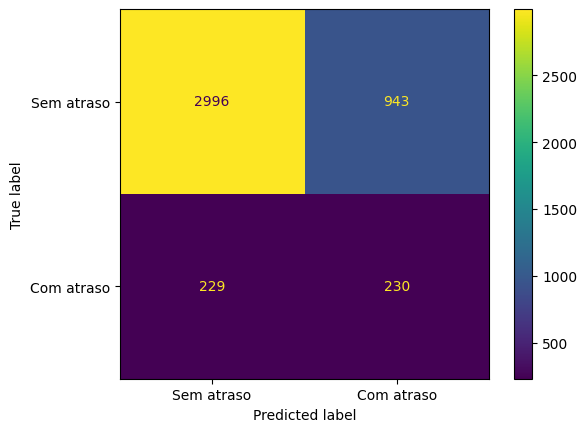


Avaliação de Classificação:
   accuracy    recall  precision  f1_weighted
1  0.733515  0.733515   0.852501     0.778529

Relatório de Classificação (por classes do target):
              precision    recall  f1-score   support

  Sem atraso       0.93      0.76      0.84      3939
  Com atraso       0.20      0.50      0.28       459

    accuracy                           0.73      4398
   macro avg       0.56      0.63      0.56      4398
weighted avg       0.85      0.73      0.78      4398



In [66]:
# Carrega o dataset
url = "https://raw.githubusercontent.com/marcos-vmiranda/pos-pucrj-mvp/main/atrasos_junho_tratados.csv"
datasetTest = pd.read_csv(url, delimiter=',')
array = datasetTest.values
# Separa as features do target
numCols = len(datasetTest.columns)
X = array[:,0:numCols-1]
y = array[:,numCols-1]

# Faz as previsões com o pipeline do melhor modelo treinado
predictions = pipe_best_model.predict(X)

# Exibe a matriz de confusão
try:
    print("\nMatriz de confusão:")
    cm=confusion_matrix(y, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem atraso', 'Com atraso'])
    disp.plot()
    plt.show()
except Exception as e:
    print("Não foi possível plotar a matriz de confusão:", e)

# Exibe os relatórios de classificação
print("\nAvaliação de Classificação:")
proba = pipe.predict_proba(X) if hasattr(pipe, "predict_proba") else None
results = {}
results[1] = avaliar_classificacao(y, predictions, proba)
print(pd.DataFrame(results).T)

print("\nRelatório de Classificação (por classes do target):")
print(classification_report(y, predictions, target_names=['Sem atraso', 'Com atraso']))



## 10. Conclusões e próximos passos

A utilização de um modelo preditivo de classificação de atrasos numa base de distribuição de combustíveis utilizando os dados históricos de viagens se mostrou viável. 

Os resultados mostraram que o modelo possui precisão suficiente para ser útil na aplicação de antecipação de chamadas de veículos.

Algumas variáveis apresentaram baixa correlação em relação ao target. Portanto, é importante buscar e analisar outros atributos possíveis e variáveis derivadas (criadas a partir de combinações dos atributos) para se tentar chegar a melhores correlações e resultados preditivos. 

Como cada base possui um comportamento próprio e um conjunto de veículos específico, será necessário treinar um modelo para cada base.

Como melhoria futura, esse projeto poderá ser integrado ao sistema de gestão operacional das bases, a fim de que seja utilizado para prever os atrasos dos veículos e possibilitar a otimização do fluxo operacional.

Para que os modelos se se mantenham atualizados, deverá ser implementado um job para treinamento automático a cada mês, a partir dos dados dos 5 meses anteriores.

Devido à necessidade de limitação do tempo de execução desse notebook no google Colab, foi necessário reduzir o número de algoritmos avaliados, como o SVC. O mesmo se aplicou à etapa de tuning dos hiperparâmetros. Alguns precisaram ser suprimidos para reduzir o tempo de execução do GridSearchCV. Sendo assim, num ambiente produtivo ainda existem algoritmos e hiperparâmetros a serem explorados para tentar encontrar melhores modelos.
